
### Project Overview

The goal of the project is to provide Youtube content creators with a way to gauge how effective a video title will be and to provide insight on which titles work best. Video titles are one of the main factors that determine whether people decide to click on a video or not. Coming up with a ‘formula’ for creating effective video titles would be advantageous to content creators. Phase I Our goal is to automate this process by using unsupervised & supervised learning to determine if there is a relationship between the structure of a title and the number of views.

We reviewed similar projects as part of our literature review and found most of the approaches that did ........ 

The common finding was that ..... 

We intend to use unsupervised learning to extract an underlying structure of video titles and use those features for prediction. This will require us to represent the features of video titles appropriately such that those features can be used by ML algorithms.  

- sarcasm score
- boring score
- remove outliers  UMAP & LOF
- choosing top_n vs bottom_n to reduce noise from average performing vidoes
- build multiple model for sub groups as titles vary too much across broad categories 
- becasuse it was found that previous video views are the strongest predictor of future views, try restricting to channels with low subscriber count
- views/subscriber count (normalizes views by subscriber count to estimate new views)
- comments/subscribers   (highly engaged viewers)
- change target to engagement which is a compination of views, likes and comments
- use topic modeling and calculate similarity to trending topics or topics in video comments
- change target to time since posted


In this notebook, I will focus on extracting and preparing the data to be used by the ML algorithms. I will also establish the baseline model performance by training some naive regressors and a linear regressor model.  

### Data Extraction & Exploration 

#### Data Extraction

Extracting the data from all json files and combining into a dataframe 

In [216]:
import os, json
import pandas as pd
import numpy as np
import glob
from datetime import datetime

dir = 'data'
path = os.path.join(dir, '**/*.json')
file_list = glob.glob(path)
print('Total number of channels ' + str(len(file_list)))

dfs = list()

for file in file_list:
    with open(file, 'r') as f:
        data = json.load(f)
    channel_id, stats = data.popitem()
    pchannel_stats = stats["channel_statistics"]
    video_stats = stats["video_data"]
    vids = video_stats.items()
    stats = []
    for vid in vids:
        video_id = vid[0]
        title = vid[1]["title"]
        try:
            views = vid[1]["viewCount"]
            likes = vid[1]["likeCount"]
            duration = vid[1]['duration']
            tags = vid[1]['tags']
            description = vid[1]['description']
            comments = vid[1]["commentCount"]
            channel = vid[1]['channelTitle']
            published = vid[1]['publishedAt'].split('T')[0]
        except:
            pass
        cat = os.path.dirname(file).split('\\')[1]
        stats.append([title,views, published, likes, comments, duration, tags, description, channel, cat])
    vid_df = pd.DataFrame(stats, columns=["title","views", 'published',"likes","comments", 'duration','tag','description', 'channel', 'category'])
    dfs.append(vid_df)
    
    
df = pd.concat(dfs, ignore_index=True)


Total number of channels 149


In [217]:
df.head()

,title,views,published,likes,comments,duration,tag,description,channel,category
0,"BART BAKER - ""POLYDOGE"" (OFFICIAL MUSIC VIDEO)",463637,2021-11-05,18410,3552,PT1M38S,"[Cryptocurrency, Crypto, Bart Baker, Doge, Shi...","""POLYDOGE"" (OFFICIAL MUSIC VIDEO)\nJoin us on...",Bart Baker,Comedy
1,WTF HAPPENED TO ME? (WHY I DISAPEARED),768016,2021-08-29,46351,11327,PT7M25S,"[BartBaker, China, Ping, SONAR, Crypto, Crypto...",I'm back. I'm sorry. Please forgive me. I love...,Bart Baker,Comedy
2,"6ix9ine, Nicki Minaj, Murda Beatz - “FEFE” PARODY",16015064,2018-08-24,262730,28384,PT4M21S,"[6ix9ine, 6ix9ine fefe, sixnine, sixnine fefe,...","6ix9ine, Nicki Minaj, Murda Beatz - ""FEFE"" PAR...",Bart Baker,Comedy
3,DESTROYING MY GOLD YOUTUBE PLAY BUTTON,1650333,2018-06-14,28664,6593,PT11M5S,"[Gold Play Button, Destroying, smashing, play ...",▶ DOWNLOAD SQUAD RIVALS - https://qkq5h.app.go...,Bart Baker,Comedy
4,"Childish Gambino - ""This Is America"" PARODY",3808210,2018-06-09,83873,12373,PT1M18S,"[This is america, childish gambino, Childish G...","""This Is America""",Bart Baker,Comedy


In [218]:
df.tail()

,title,views,published,likes,comments,duration,tag,description,channel,category
55332,Downward Dog - Downward Facing Dog Yoga Pose,1327691,2012-12-12,13997,565,PT7M58S,"[downward dog, down dog, downward facing dog, ...",Learn Downward Dog yoga pose with Adriene. If ...,Yoga With Adriene,Yoga
55333,Reclined Twist Yoga Pose - Yoga With Adriene,162174,2012-11-14,2397,116,PT8M40S,"[yoga, adriene mishler, yoga with adriene, yog...",Learn the Reclined Twist Yoga Pose with Adrien...,Yoga With Adriene,Yoga
55334,Corpse Pose - Yoga With Adriene,336507,2012-10-31,4589,249,PT9M27S,"[yoga for beginners, yoga with adriene, founda...",Learn how to do the Corpse Pose with Adriene! ...,Yoga With Adriene,Yoga
55335,Extended Child's Pose - Yoga With Adriene,1451610,2012-10-24,11649,373,PT6M14S,"[extended child's pose, yoga for beginners, ch...",Learn Extended Child's Pose with Adriene! This...,Yoga With Adriene,Yoga
55336,Runner's Lunge - Foundations of Yoga,247577,2012-10-10,3364,165,PT6M4S,"[yoga for beginners, yoga with adriene, adrien...",Learn Runner's Lunge with Adriene! (Not just f...,Yoga With Adriene,Yoga


In [219]:
df.isna().sum()
#df.views = (df.views).astype(int)

title          0
views          0
published      0
likes          0
comments       0
duration       0
tag            0
description    0
channel        0
category       0
dtype: int64

In [220]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55337 entries, 0 to 55336
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        55337 non-null  object
 1   views        55337 non-null  object
 2   published    55337 non-null  object
 3   likes        55337 non-null  object
 4   comments     55337 non-null  object
 5   duration     55337 non-null  object
 6   tag          55337 non-null  object
 7   description  55337 non-null  object
 8   channel      55337 non-null  object
 9   category     55337 non-null  object
dtypes: object(10)
memory usage: 4.2+ MB


In [221]:
# Let's get the length of the titles
df['length'] = df['title'].apply(len)

In [222]:
df['views'] = df["views"]. apply(lambda x: int(x))

In [223]:
df.published = pd.to_datetime(df.published, format='%Y-%m-%d')
df.shape

(55337, 11)

In [224]:
def top10():
    
    """This function sorts the data by views and title and selects the top 10 titles"""
    
    df_sorted = df.sort_values(['views','title'], ascending=[False,True])[:10]
    
    return df_sorted[['title','views']]

top10()  # mostly popular songs at the top. We will probably have to remove this category 

,title,views
29266,Ed Sheeran - Shape of You (Official Music Video),5809870270
31988,El Chombo - Dame Tu Cosita feat. Cutty Ranks (...,4074952447
29286,Ed Sheeran - Thinking Out Loud (Official Music...,3499179932
29241,Ed Sheeran - Perfect (Official Music Video),3256243151
29088,Bruno Mars - The Lazy Song (Official Music Video),2416952328
29051,Bruno Mars - That’s What I Like [Official Musi...,2061152302
29098,Bruno Mars - Just The Way You Are (Official Mu...,1752542816
29062,Bruno Mars - 24K Magic (Official Music Video),1532258215
29275,Ed Sheeran - Photograph (Official Music Video),1238010919
32101,OMI - Cheerleader (Felix Jaehn Remix) [Officia...,1193639342


In [225]:
def bottom10():
    
    """This function sorts the data by views and title and selects the top 10 titles"""
    
    df_sorted = df.sort_values(['views','title'], ascending=[True,True])[:10]
    
    return df_sorted[['title','views']]

bottom10() # we will have to consider removing titles with no views. 

,title,views
21475,10-Minute Dance Cardio Workout With Charlize G...,0
21474,10-Minute Feel-Good Standing Workout With Rach...,0
21477,"10-Minute, No-Equipment Cardio HIIT With Ranei...",0
29522,ROUND 2 LDN,0
27869,"TIMELINE 1975 - Evel Knievel, The Holy Grail A...",0
6251,The Road to Cooking | Carolina Gelen and Artic...,0
6252,The Road to Cooking | Eric Adjepong and Roaste...,0
6254,The Road to Cooking | Grant Crilly and Oysters...,0
6247,The Road to Cooking | Gregory Gourdet and Smok...,0
6248,The Road to Cooking | Nik Sharma and Dutch Bab...,0


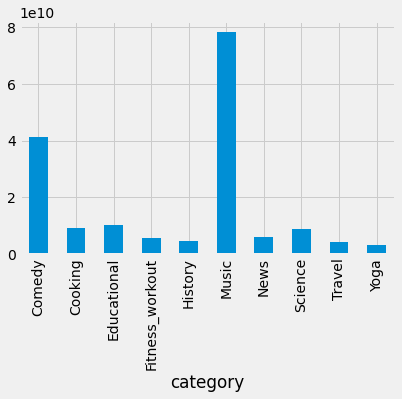

In [226]:
df.groupby('category').views.agg('sum').plot(kind='bar');

In [227]:
df[df['category']=='Comedy'].head(10)

,title,views,published,likes,comments,duration,tag,description,channel,category,length
0,"BART BAKER - ""POLYDOGE"" (OFFICIAL MUSIC VIDEO)",463637,2021-11-05,18410,3552,PT1M38S,"[Cryptocurrency, Crypto, Bart Baker, Doge, Shi...","""POLYDOGE"" (OFFICIAL MUSIC VIDEO)\nJoin us on...",Bart Baker,Comedy,47
1,WTF HAPPENED TO ME? (WHY I DISAPEARED),768016,2021-08-29,46351,11327,PT7M25S,"[BartBaker, China, Ping, SONAR, Crypto, Crypto...",I'm back. I'm sorry. Please forgive me. I love...,Bart Baker,Comedy,38
2,"6ix9ine, Nicki Minaj, Murda Beatz - “FEFE” PARODY",16015064,2018-08-24,262730,28384,PT4M21S,"[6ix9ine, 6ix9ine fefe, sixnine, sixnine fefe,...","6ix9ine, Nicki Minaj, Murda Beatz - ""FEFE"" PAR...",Bart Baker,Comedy,49
3,DESTROYING MY GOLD YOUTUBE PLAY BUTTON,1650333,2018-06-14,28664,6593,PT11M5S,"[Gold Play Button, Destroying, smashing, play ...",▶ DOWNLOAD SQUAD RIVALS - https://qkq5h.app.go...,Bart Baker,Comedy,38
4,"Childish Gambino - ""This Is America"" PARODY",3808210,2018-06-09,83873,12373,PT1M18S,"[This is america, childish gambino, Childish G...","""This Is America""",Bart Baker,Comedy,43
5,"Lil Pump - ""ESSKEETIT"" PARODY",4420488,2018-05-26,86195,6707,PT2M37S,"[Lil Pump, Esskeetit, Lil, Pump, official musi...","Family friendly PG clean Lil Pump ""Esskeetit"" ...",Bart Baker,Comedy,29
6,I'm Sorry Taylor Swift,1569187,2018-03-21,33126,4371,PT2M35S,"[I'm Sorry, Taylor Swift, Delicate, Taylor Swi...",I'm sorry for what I said at the end of my lat...,Bart Baker,Comedy,22
7,My Channel Is Being Shut Down (What YouTube is...,1553015,2018-02-20,64249,8218,PT6M22S,"[YouTube, Bart Baker, Parody, Parodies, BartBa...",▶ BE BRAVE - SAVE MY CHANNEL - https://brave.c...,Bart Baker,Comedy,73
8,LOGAN PAUL IS BACK! PARODY,1272945,2018-02-15,39781,5275,PT5M58S,"[Logan Paul, Logan Paul is back, Logan Paul Vl...",LOGAN PAUL IS BACK & is launching a cryptocurr...,Bart Baker,Comedy,26
9,"Bruno Mars ft. Cardi B - ""Finesse"" (Remix) PARODY",8354736,2018-01-27,125713,14194,PT3M12S,"[Cardi B, Bruno Mars, Finesse, Finesse Remix, ...",Bruno Mars ft. Cardi B - Finesse (Remix) PAROD...,Bart Baker,Comedy,49


In [228]:
df.describe()

,views,length
count,5.533700e+04,55337.000000
mean,3.105545e+06,50.675859
std,4.480374e+07,19.791702
min,0.000000e+00,0.000000
25%,8.557700e+04,36.000000
50%,3.154620e+05,49.000000
75%,1.310440e+06,64.000000
max,5.809870e+09,100.000000


In [229]:
# Let's see the shortest titles
df[df['length'] == 0]['title'].iloc[0]

''

In [230]:
# Let's see some of the shorter titles
[df[df['length'] == 10]['title'].iloc[0], df[df['length'] == 15]['title'].iloc[0],df[df['length'] == 20]['title'].iloc[0]]

['WiNNiNG!!!', 'Please Grade Me', 'All Scars Are Badass']

In [231]:
# Let's view the title with mean length 
df[df['length'] == 50]['title'].iloc[0]

'Jake Paul ft. Team 10 - "It\'s Everyday Bro" PARODY'

<AxesSubplot:ylabel='Frequency'>

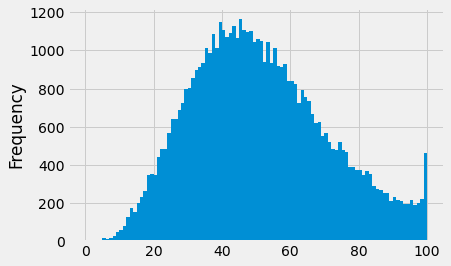

In [232]:
import matplotlib.pyplot as plt

# Plot the histogram of the length column
df['length'].plot(bins=100, kind='hist') 

In [233]:
titles = df['title'].tolist()
len(titles)

55337

In [234]:
titles_as_one_string =" ".join(titles)

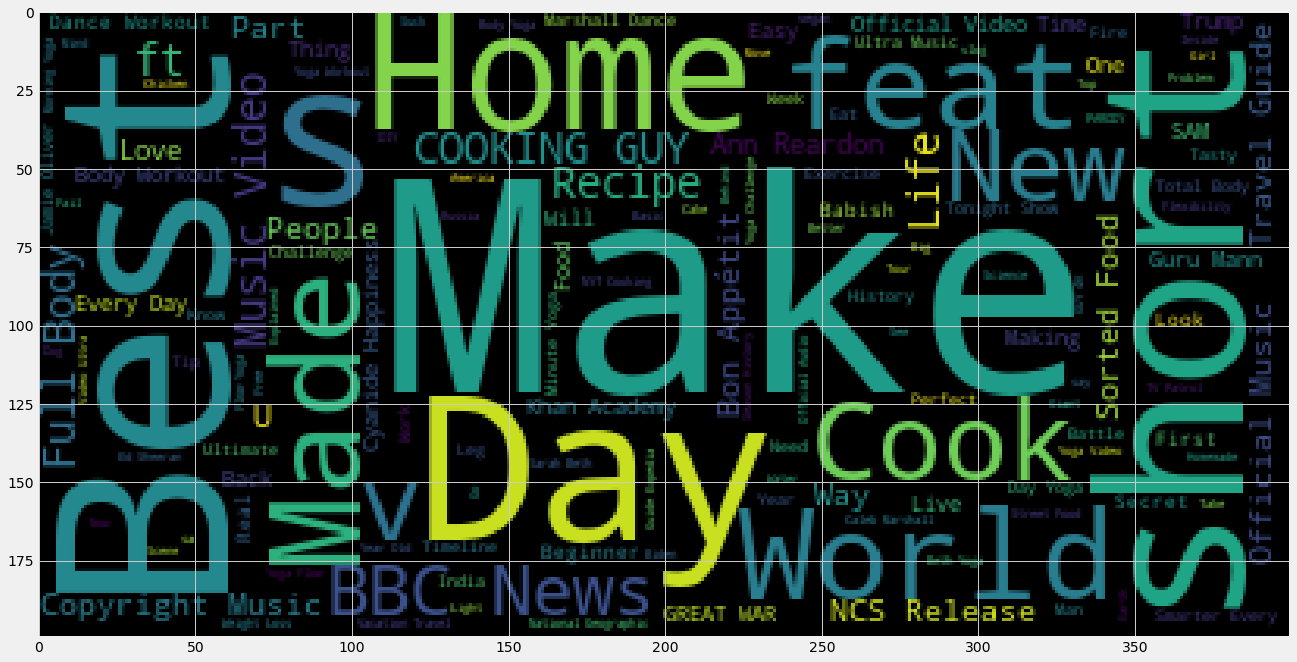

In [235]:
from wordcloud import WordCloud

plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(titles_as_one_string))

#### Splitting our data into train, dev and test sets 

In [10]:
# Splitting the data in 80%, 10%, 10% train, dev and test sets

RANDOM_SEED = 42

train_df, dev_df, test_df = np.split(df.sample(frac=1, random_state=RANDOM_SEED),[int(.8*len(df)), int(.9*len(df))])

print(len(train_df), len(dev_df), len(test_df))

44269 5534 5534


#### Converting the titles to features 

In [11]:
from sklearn.dummy import DummyRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# fitting a vectorizer
# We will use 50 for min_df to ensure that a word shows up at least 50 times. 
# We will also specify that english stop words are to be removed and 
# We will use unigrams and bigrams

vectorizer = TfidfVectorizer(min_df=50,stop_words='english',ngram_range=(1, 2))
X_train = vectorizer.fit_transform(train_df.title)

In [12]:
X_train.shape  # We found 619 word features 

(44269, 1051)

In [13]:
# getting list of labels 
y_train = list(train_df.views)

#### Fit a unigram and bigram LinearRegression classifier

In [14]:
reg = LinearRegression()
reg.fit(X_train,y_train)

LinearRegression()

#### Generating development data 

In [15]:
X_dev = vectorizer.transform(dev_df.title)
y_dev = list(dev_df.views)

#### Create Dummy Classifiers 

In [16]:
dummy_clf_mean = DummyRegressor(strategy="mean")
dummy_clf_mean.fit(X_train, y_train)
dummy_clf_median = DummyRegressor(strategy="median")
dummy_clf_median.fit(X_train, y_train)

DummyRegressor(strategy='median')

#### Generating all the predictions 

In [17]:
lr_dev_preds = reg.predict(X_dev)
mean_dev_preds = dummy_clf_mean.predict(X_dev)
median_dev_preds = dummy_clf_median.predict(X_dev)

#### Scoring the predictions

In [18]:
lr_mse = mean_squared_error(y_dev, lr_dev_preds)
mean_mse = mean_squared_error(y_dev, mean_dev_preds)
median_mse = mean_squared_error(y_dev, median_dev_preds)

In [19]:
print(lr_mse)
print(mean_mse)
print(median_mse)

1265977741186676.2
1427213821206073.2
1435680290767539.0


#### Based on feedback from Miles, changing the target to average views since posted since the number of views heavily depends on how long ago the video was posted. 

In [20]:
from datetime import date

df['Today'] = datetime.today().strftime('%Y-%m-%d') 
df.Today = pd.to_datetime(df.Today, format='%Y-%m-%d')
df.head()

,title,views,published,likes,comments,duration,tag,description,channel,category,Today
0,"BART BAKER - ""POLYDOGE"" (OFFICIAL MUSIC VIDEO)",463637,2021-11-05,18410,3552,PT1M38S,"[Cryptocurrency, Crypto, Bart Baker, Doge, Shi...","""POLYDOGE"" (OFFICIAL MUSIC VIDEO)\nJoin us on...",Bart Baker,Comedy,2022-10-19
1,WTF HAPPENED TO ME? (WHY I DISAPEARED),768016,2021-08-29,46351,11327,PT7M25S,"[BartBaker, China, Ping, SONAR, Crypto, Crypto...",I'm back. I'm sorry. Please forgive me. I love...,Bart Baker,Comedy,2022-10-19
2,"6ix9ine, Nicki Minaj, Murda Beatz - “FEFE” PARODY",16015064,2018-08-24,262730,28384,PT4M21S,"[6ix9ine, 6ix9ine fefe, sixnine, sixnine fefe,...","6ix9ine, Nicki Minaj, Murda Beatz - ""FEFE"" PAR...",Bart Baker,Comedy,2022-10-19
3,DESTROYING MY GOLD YOUTUBE PLAY BUTTON,1650333,2018-06-14,28664,6593,PT11M5S,"[Gold Play Button, Destroying, smashing, play ...",▶ DOWNLOAD SQUAD RIVALS - https://qkq5h.app.go...,Bart Baker,Comedy,2022-10-19
4,"Childish Gambino - ""This Is America"" PARODY",3808210,2018-06-09,83873,12373,PT1M18S,"[This is america, childish gambino, Childish G...","""This Is America""",Bart Baker,Comedy,2022-10-19


In [21]:
df['days since'] = df['Today'] - df['published']

In [22]:
df.head()

,title,views,published,likes,comments,duration,tag,description,channel,category,Today,days since
0,"BART BAKER - ""POLYDOGE"" (OFFICIAL MUSIC VIDEO)",463637,2021-11-05,18410,3552,PT1M38S,"[Cryptocurrency, Crypto, Bart Baker, Doge, Shi...","""POLYDOGE"" (OFFICIAL MUSIC VIDEO)\nJoin us on...",Bart Baker,Comedy,2022-10-19,348 days
1,WTF HAPPENED TO ME? (WHY I DISAPEARED),768016,2021-08-29,46351,11327,PT7M25S,"[BartBaker, China, Ping, SONAR, Crypto, Crypto...",I'm back. I'm sorry. Please forgive me. I love...,Bart Baker,Comedy,2022-10-19,416 days
2,"6ix9ine, Nicki Minaj, Murda Beatz - “FEFE” PARODY",16015064,2018-08-24,262730,28384,PT4M21S,"[6ix9ine, 6ix9ine fefe, sixnine, sixnine fefe,...","6ix9ine, Nicki Minaj, Murda Beatz - ""FEFE"" PAR...",Bart Baker,Comedy,2022-10-19,1517 days
3,DESTROYING MY GOLD YOUTUBE PLAY BUTTON,1650333,2018-06-14,28664,6593,PT11M5S,"[Gold Play Button, Destroying, smashing, play ...",▶ DOWNLOAD SQUAD RIVALS - https://qkq5h.app.go...,Bart Baker,Comedy,2022-10-19,1588 days
4,"Childish Gambino - ""This Is America"" PARODY",3808210,2018-06-09,83873,12373,PT1M18S,"[This is america, childish gambino, Childish G...","""This Is America""",Bart Baker,Comedy,2022-10-19,1593 days


In [23]:
df['days since'] = df['days since'].apply(lambda x: x.days)

df.head()

,title,views,published,likes,comments,duration,tag,description,channel,category,Today,days since
0,"BART BAKER - ""POLYDOGE"" (OFFICIAL MUSIC VIDEO)",463637,2021-11-05,18410,3552,PT1M38S,"[Cryptocurrency, Crypto, Bart Baker, Doge, Shi...","""POLYDOGE"" (OFFICIAL MUSIC VIDEO)\nJoin us on...",Bart Baker,Comedy,2022-10-19,348
1,WTF HAPPENED TO ME? (WHY I DISAPEARED),768016,2021-08-29,46351,11327,PT7M25S,"[BartBaker, China, Ping, SONAR, Crypto, Crypto...",I'm back. I'm sorry. Please forgive me. I love...,Bart Baker,Comedy,2022-10-19,416
2,"6ix9ine, Nicki Minaj, Murda Beatz - “FEFE” PARODY",16015064,2018-08-24,262730,28384,PT4M21S,"[6ix9ine, 6ix9ine fefe, sixnine, sixnine fefe,...","6ix9ine, Nicki Minaj, Murda Beatz - ""FEFE"" PAR...",Bart Baker,Comedy,2022-10-19,1517
3,DESTROYING MY GOLD YOUTUBE PLAY BUTTON,1650333,2018-06-14,28664,6593,PT11M5S,"[Gold Play Button, Destroying, smashing, play ...",▶ DOWNLOAD SQUAD RIVALS - https://qkq5h.app.go...,Bart Baker,Comedy,2022-10-19,1588
4,"Childish Gambino - ""This Is America"" PARODY",3808210,2018-06-09,83873,12373,PT1M18S,"[This is america, childish gambino, Childish G...","""This Is America""",Bart Baker,Comedy,2022-10-19,1593


In [24]:
df['avg_views_since_pub'] = df['views'] / df['days since']
df.head()

,title,views,published,likes,comments,duration,tag,description,channel,category,Today,days since,avg_views_since_pub
0,"BART BAKER - ""POLYDOGE"" (OFFICIAL MUSIC VIDEO)",463637,2021-11-05,18410,3552,PT1M38S,"[Cryptocurrency, Crypto, Bart Baker, Doge, Shi...","""POLYDOGE"" (OFFICIAL MUSIC VIDEO)\nJoin us on...",Bart Baker,Comedy,2022-10-19,348,1332.290230
1,WTF HAPPENED TO ME? (WHY I DISAPEARED),768016,2021-08-29,46351,11327,PT7M25S,"[BartBaker, China, Ping, SONAR, Crypto, Crypto...",I'm back. I'm sorry. Please forgive me. I love...,Bart Baker,Comedy,2022-10-19,416,1846.192308
2,"6ix9ine, Nicki Minaj, Murda Beatz - “FEFE” PARODY",16015064,2018-08-24,262730,28384,PT4M21S,"[6ix9ine, 6ix9ine fefe, sixnine, sixnine fefe,...","6ix9ine, Nicki Minaj, Murda Beatz - ""FEFE"" PAR...",Bart Baker,Comedy,2022-10-19,1517,10557.062624
3,DESTROYING MY GOLD YOUTUBE PLAY BUTTON,1650333,2018-06-14,28664,6593,PT11M5S,"[Gold Play Button, Destroying, smashing, play ...",▶ DOWNLOAD SQUAD RIVALS - https://qkq5h.app.go...,Bart Baker,Comedy,2022-10-19,1588,1039.252519
4,"Childish Gambino - ""This Is America"" PARODY",3808210,2018-06-09,83873,12373,PT1M18S,"[This is america, childish gambino, Childish G...","""This Is America""",Bart Baker,Comedy,2022-10-19,1593,2390.590082


#### From looking at the highest view vidoes, they appear to be music vidoes where the title is the name of the music vidoes. These video titles. We decided to exclude those vidoes as they likely reduce the model's performance 

In [25]:
def top10():
    
    """This function sorts the data by views and title and selects the top 10 titles"""
    
    df_sorted = df.sort_values(['views','title'], ascending=[False,True])[:10]
    
    return df_sorted[['title','views','category']]

top10()

,title,views,category
29266,Ed Sheeran - Shape of You (Official Music Video),5809870270,Music
31988,El Chombo - Dame Tu Cosita feat. Cutty Ranks (...,4074952447,Music
29286,Ed Sheeran - Thinking Out Loud (Official Music...,3499179932,Music
29241,Ed Sheeran - Perfect (Official Music Video),3256243151,Music
29088,Bruno Mars - The Lazy Song (Official Music Video),2416952328,Music
29051,Bruno Mars - That’s What I Like [Official Musi...,2061152302,Music
29098,Bruno Mars - Just The Way You Are (Official Mu...,1752542816,Music
29062,Bruno Mars - 24K Magic (Official Music Video),1532258215,Music
29275,Ed Sheeran - Photograph (Official Music Video),1238010919,Music
32101,OMI - Cheerleader (Felix Jaehn Remix) [Officia...,1193639342,Music


In [26]:
len(df)

55337

In [27]:
# removing the music genre

df.drop(df[df.category == 'Music'].index, inplace=True)

In [28]:
def top10():
    
    """This function sorts the data by views and title and selects the top 10 titles"""
    
    df_sorted = df.sort_values(['views','title'], ascending=[False,True])[:10]
    
    return df_sorted[['title','views','category']]

top10()

,title,views,category
2042,Lele Pons & Guaynaa - Se Te Nota (Official Mus...,408495885,Comedy
3462,Disney Princess Pool Party,384451618,Comedy
2088,Lele Pons - Celoso (Official Music Video),376009768,Comedy
2110,Anitta & J Balvin - Downtown (Official Lyric V...,351444004,Comedy
4714,I Just Had Sex (feat. Akon),336203265,Comedy
4706,Jack Sparrow (feat. Michael Bolton),228309166,Comedy
2149,"Super Mario Run | Lele Pons, Rudy Mancuso & J...",212972757,Comedy
3452,Super Hero Carpool Ride,194316056,Comedy
114,"Katy Perry ft. Juicy J - ""Dark Horse"" PARODY",191898849,Comedy
4739,Like A Boss (ft. Seth Rogen) - Uncensored Version,176702648,Comedy


In [127]:
len(df)

51416

#### Now to test the model performance again

In [30]:
RANDOM_SEED = 42

train_df, dev_df, test_df = np.split(df.sample(frac=1, random_state=RANDOM_SEED),[int(.8*len(df)), int(.9*len(df))])

print(len(train_df), len(dev_df), len(test_df))

41132 5142 5142


In [31]:
vectorizer = TfidfVectorizer(min_df=50,stop_words='english',ngram_range=(1, 2))
X_train = vectorizer.fit_transform(train_df.title)
print(X_train.shape)

(41132, 979)


In [32]:
# getting list of labels 
y_train = list(train_df.avg_views_since_pub)

In [33]:
reg = LinearRegression()
reg.fit(X_train,y_train)

X_dev = vectorizer.transform(dev_df.title)

y_dev = list(dev_df.avg_views_since_pub)

dummy_clf_mean = DummyRegressor(strategy="mean")
dummy_clf_mean.fit(X_train, y_train)
dummy_clf_median = DummyRegressor(strategy="median")
dummy_clf_median.fit(X_train, y_train)

lr_dev_preds = reg.predict(X_dev)
mean_dev_preds = dummy_clf_mean.predict(X_dev)
median_dev_preds = dummy_clf_median.predict(X_dev)

lr_mse = mean_squared_error(y_dev, lr_dev_preds)
mean_mse = mean_squared_error(y_dev, mean_dev_preds)
median_mse = mean_squared_error(y_dev, median_dev_preds)

print(lr_mse)
print(mean_mse)
print(median_mse)

76278642.56490879
83104063.35421954
85533672.21347654


#### We achieved a signficant improvment from our two adjustments 

#### We are now going to test some more feature engineering steps, starting with changing the target to a new calculated field. The incremental views a video gained.   

In [34]:
channel_df = df[['title','channel','published','views']]

In [35]:
channel_df.head()

,title,channel,published,views
0,"BART BAKER - ""POLYDOGE"" (OFFICIAL MUSIC VIDEO)",Bart Baker,2021-11-05,463637
1,WTF HAPPENED TO ME? (WHY I DISAPEARED),Bart Baker,2021-08-29,768016
2,"6ix9ine, Nicki Minaj, Murda Beatz - “FEFE” PARODY",Bart Baker,2018-08-24,16015064
3,DESTROYING MY GOLD YOUTUBE PLAY BUTTON,Bart Baker,2018-06-14,1650333
4,"Childish Gambino - ""This Is America"" PARODY",Bart Baker,2018-06-09,3808210


In [36]:
channel_df = channel_df.sort_values(['channel', 'published'], ascending=[True, True])

In [37]:
channel_df.head()

,title,channel,published,views
15149,Millions of Cars Are Rotting in the Open Air,#Mind Warehouse,2019-02-17,1563100
15148,9 People You Don't Want to Mess With,#Mind Warehouse,2019-03-09,17760632
15147,Things That You Will See for the First Time in...,#Mind Warehouse,2019-03-10,2464557
15146,40 Most Unbelievable Coincidences in the World!,#Mind Warehouse,2019-03-14,5324119
15145,10 Strongest People on the Planet,#Mind Warehouse,2019-03-23,2435017


In [38]:
df[['channel','avg_views_since_pub']].head()

,channel,avg_views_since_pub
0,Bart Baker,1332.290230
1,Bart Baker,1846.192308
2,Bart Baker,10557.062624
3,Bart Baker,1039.252519
4,Bart Baker,2390.590082


In [39]:
channel_dict = {}
    
for channel in list(df["channel"].unique()):
    
    channel_dict[channel] = df[['channel','avg_views_since_pub']].groupby(by="channel", dropna=False).mean().loc[channel][0]
    
channel_dict    

{'Bart Baker': 5760.865911891857,
 'CollegeHumor': 1187.5536647651359,
 'ExplosmEntertainment': 2618.2597772760564,
 'FailArmy': 18928.64730263475,
 'JennaMarbles': 3957.389863198951,
 'Jesse': 2798.58082978212,
 'Lele Pons': 22518.99079928353,
 'Lilly Singh': 2453.3763836446196,
 'Liza Koshy': 7613.432909955362,
 'nigahiga': 3671.880165128846,
 'Rclbeauty101': 3996.2194433706454,
 'shane': 4828.034209507831,
 'Smosh': 3462.2674333437217,
 'thelonelyisland': 4801.264290420077,
 'The Tonight Show Starring Jimmy Fallon': 5603.473565879398,
 'Babish Culinary Universe': 5601.589804394997,
 'Bon Appétit': 2189.869343050845,
 'ChefSteps': 127.21639553562562,
 'Epic Meal Time': 436.9335303325015,
 'Everyday Food': 102.76934246766544,
 'French Cooking Academy': 114.3143271336722,
 'How To Cook That': 1374.4099970798065,
 'Jamie Oliver': 497.1924699966626,
 'Joshua Weissman': 4917.345050799395,
 'JunsKitchen': 6574.213251741953,
 'Laura in the Kitchen': 180.87402503237732,
 'Maangchi': 851.5781

In [40]:
df['average']=df['channel'].apply(lambda x: channel_dict[x])

In [41]:
df[df["channel"]=='The Tonight Show Starring Jimmy Fallon'].head(3)

,title,views,published,likes,comments,duration,tag,description,channel,category,Today,days since,avg_views_since_pub,average
4774,"Trump Gets Sued by NY's Attorney General, Bide...",91546,2022-09-25,1706,262,PT30M55S,"[tonight show, jimmy fallon, Sean Hannity, cla...",Jimmy talks about Trump making wild claims abo...,The Tonight Show Starring Jimmy Fallon,Comedy,2022-10-19,24,3814.416667,5603.473566
4775,"The Best of Box of Lies Vol. 1 ft. Cardi B, Ta...",63891,2022-09-24,1206,52,PT14M41S,"[tonight show, jimmy fallon, NBC, NBC TV, Tele...","Jimmy faces off against Nicole Kidman, Matt Da...",The Tonight Show Starring Jimmy Fallon,Comedy,2022-10-19,25,2555.640000,5603.473566
4776,The Smashing Pumpkins: Beguiled | The Tonight ...,90251,2022-09-24,3054,690,PT4M29S,"[tonight show, jimmy fallon, NBC, NBC TV, Tele...","Musical guest The Smashing Pumpkins perform ""B...",The Tonight Show Starring Jimmy Fallon,Comedy,2022-10-19,25,3610.040000,5603.473566


In [42]:
df['var_from_average']= df['avg_views_since_pub'] - df['average']

df.head()

,title,views,published,likes,comments,duration,tag,description,channel,category,Today,days since,avg_views_since_pub,average,var_from_average
0,"BART BAKER - ""POLYDOGE"" (OFFICIAL MUSIC VIDEO)",463637,2021-11-05,18410,3552,PT1M38S,"[Cryptocurrency, Crypto, Bart Baker, Doge, Shi...","""POLYDOGE"" (OFFICIAL MUSIC VIDEO)\nJoin us on...",Bart Baker,Comedy,2022-10-19,348,1332.290230,5760.865912,-4428.575682
1,WTF HAPPENED TO ME? (WHY I DISAPEARED),768016,2021-08-29,46351,11327,PT7M25S,"[BartBaker, China, Ping, SONAR, Crypto, Crypto...",I'm back. I'm sorry. Please forgive me. I love...,Bart Baker,Comedy,2022-10-19,416,1846.192308,5760.865912,-3914.673604
2,"6ix9ine, Nicki Minaj, Murda Beatz - “FEFE” PARODY",16015064,2018-08-24,262730,28384,PT4M21S,"[6ix9ine, 6ix9ine fefe, sixnine, sixnine fefe,...","6ix9ine, Nicki Minaj, Murda Beatz - ""FEFE"" PAR...",Bart Baker,Comedy,2022-10-19,1517,10557.062624,5760.865912,4796.196712
3,DESTROYING MY GOLD YOUTUBE PLAY BUTTON,1650333,2018-06-14,28664,6593,PT11M5S,"[Gold Play Button, Destroying, smashing, play ...",▶ DOWNLOAD SQUAD RIVALS - https://qkq5h.app.go...,Bart Baker,Comedy,2022-10-19,1588,1039.252519,5760.865912,-4721.613393
4,"Childish Gambino - ""This Is America"" PARODY",3808210,2018-06-09,83873,12373,PT1M18S,"[This is america, childish gambino, Childish G...","""This Is America""",Bart Baker,Comedy,2022-10-19,1593,2390.590082,5760.865912,-3370.275830


In [43]:
RANDOM_SEED = 42

train_df, dev_df, test_df = np.split(df.sample(frac=1, random_state=RANDOM_SEED),[int(.8*len(df)), int(.9*len(df))])

vectorizer = TfidfVectorizer(min_df=50,stop_words='english',ngram_range=(1, 2))
X_train = vectorizer.fit_transform(train_df.title)

# getting list of labels 
y_train = list(train_df.var_from_average)

reg = LinearRegression()
reg.fit(X_train,y_train)

X_dev = vectorizer.transform(dev_df.title)

y_dev = list(dev_df.var_from_average)

dummy_clf_mean = DummyRegressor(strategy="mean")
dummy_clf_mean.fit(X_train, y_train)
dummy_clf_median = DummyRegressor(strategy="median")
dummy_clf_median.fit(X_train, y_train)

lr_dev_preds = reg.predict(X_dev)
mean_dev_preds = dummy_clf_mean.predict(X_dev)
median_dev_preds = dummy_clf_median.predict(X_dev)

lr_mse = mean_squared_error(y_dev, lr_dev_preds)
mean_mse = mean_squared_error(y_dev, mean_dev_preds)
median_mse = mean_squared_error(y_dev, median_dev_preds)

print(lr_mse)
print(mean_mse)
print(median_mse)

73742339.90900292
74858373.49389502
74917560.97867344


#### Using variance from the mean does not appear to have increased the performance relavtive to the baseline dummy models

In [44]:
RANDOM_SEED = 42

train_df, dev_df, test_df = np.split(df.sample(frac=1, random_state=RANDOM_SEED),[int(.8*len(df)), int(.9*len(df))])

vectorizer = TfidfVectorizer(min_df=50,stop_words='english',ngram_range=(1, 2))
X_train = vectorizer.fit_transform(train_df.title)

# getting list of labels 
y_train = list(train_df.avg_views_since_pub)

reg = LinearRegression()
reg.fit(X_train,y_train)

X_dev = vectorizer.transform(dev_df.title)

y_dev = list(dev_df.avg_views_since_pub)

dummy_clf_mean = DummyRegressor(strategy="mean")
dummy_clf_mean.fit(X_train, y_train)
dummy_clf_median = DummyRegressor(strategy="median")
dummy_clf_median.fit(X_train, y_train)

lr_dev_preds = reg.predict(X_dev)
mean_dev_preds = dummy_clf_mean.predict(X_dev)
median_dev_preds = dummy_clf_median.predict(X_dev)

lr_mse = mean_squared_error(y_dev, lr_dev_preds)
mean_mse = mean_squared_error(y_dev, mean_dev_preds)
median_mse = mean_squared_error(y_dev, median_dev_preds)

print(lr_mse)
print(mean_mse)
print(median_mse)

76278642.56490879
83104063.35421954
85533672.21347654


#### Testing model perfromance using single categories

In [45]:
news_df = df[df["category"]=="News"]
news_df.head()

,title,views,published,likes,comments,duration,tag,description,channel,category,Today,days since,avg_views_since_pub,average,var_from_average
32273,Abortion battle divides struggling Illinois to...,2417,2022-09-27,31,29,PT8M25S,"[Abortion, City, Granite, Illinois, abc, abcnl...",ABC News’ Linsey Davis travels to Granite City...,ABC News,News,2022-10-19,22,109.863636,1462.633518,-1352.769882
32274,NASA spacecraft successfully collides with ast...,17273,2022-09-27,260,116,PT5M21S,"[Cady, Coleman, NASA, abc, abcnl, asteroid, as...",ABC News’ Linsey Davis spoke with ABC News con...,ABC News,News,2022-10-19,22,785.136364,1462.633518,-677.497155
32275,ABC News Prime: Tracking Hurricane Ian; NASA's...,53821,2022-09-27,932,59,PT1H34M39S,"[news, abc news, politics news, trump raide, t...",#abcnews #hurricane #russia\n\nWatch More on h...,ABC News,News,2022-10-19,22,2446.409091,1462.633518,983.775572
32276,Millions face starvation in Somalia,4974,2022-09-27,80,78,PT3M16S,"[ABC, News, Somalia, Tonight, World, eating, f...",Historic drought and rising food prices have l...,ABC News,News,2022-10-19,22,226.090909,1462.633518,-1236.542609
32277,Preparations underway in Florida as Hurricane ...,16355,2022-09-26,146,54,PT4M37S,"[ABC, ABCNL, Center, Coast, Florida, Gulf, Hur...","Michael Brennan, deputy director of the Nation...",ABC News,News,2022-10-19,23,711.086957,1462.633518,-751.546562


In [46]:
RANDOM_SEED = 42

train_df, dev_df, test_df = np.split(news_df.sample(frac=1, random_state=RANDOM_SEED),[int(.8*len(news_df)), int(.9*len(news_df))])

vectorizer = TfidfVectorizer(min_df=50,stop_words='english',ngram_range=(1, 2))
X_train = vectorizer.fit_transform(train_df.title)

# getting list of labels 
y_train = list(train_df.avg_views_since_pub)

reg = LinearRegression()
reg.fit(X_train,y_train)

X_dev = vectorizer.transform(dev_df.title)

y_dev = list(dev_df.avg_views_since_pub)

dummy_clf_mean = DummyRegressor(strategy="mean")
dummy_clf_mean.fit(X_train, y_train)
dummy_clf_median = DummyRegressor(strategy="median")
dummy_clf_median.fit(X_train, y_train)

lr_dev_preds = reg.predict(X_dev)
mean_dev_preds = dummy_clf_mean.predict(X_dev)
median_dev_preds = dummy_clf_median.predict(X_dev)

lr_mse = mean_squared_error(y_dev, lr_dev_preds)
mean_mse = mean_squared_error(y_dev, mean_dev_preds)
median_mse = mean_squared_error(y_dev, median_dev_preds)

print(lr_mse)
print(mean_mse)
print(median_mse)

19464933.44235281
18983943.771157067
21375356.530081633


#### Using a single category "news" lowered all mean squared error scores however reduced the difference between the linear model and the dummy models 

In [47]:
df['category'].unique()

array(['Comedy', 'Cooking', 'Educational', 'Fitness_workout', 'History',
       'News', 'Science', 'Travel', 'Yoga'], dtype=object)

In [48]:
comedy_df = df[df["category"]=="Comedy"]

In [49]:
RANDOM_SEED = 42

train_df, dev_df, test_df = np.split(comedy_df.sample(frac=1, random_state=RANDOM_SEED),[int(.8*len(comedy_df)), int(.9*len(comedy_df))])

vectorizer = TfidfVectorizer(min_df=50,stop_words='english',ngram_range=(1, 2))
X_train = vectorizer.fit_transform(train_df.title)

# getting list of labels 
y_train = list(train_df.avg_views_since_pub)

reg = LinearRegression()
reg.fit(X_train,y_train)

X_dev = vectorizer.transform(dev_df.title)

y_dev = list(dev_df.avg_views_since_pub)

dummy_clf_mean = DummyRegressor(strategy="mean")
dummy_clf_mean.fit(X_train, y_train)
dummy_clf_median = DummyRegressor(strategy="median")
dummy_clf_median.fit(X_train, y_train)

lr_dev_preds = reg.predict(X_dev)
mean_dev_preds = dummy_clf_mean.predict(X_dev)
median_dev_preds = dummy_clf_median.predict(X_dev)

lr_mse = mean_squared_error(y_dev, lr_dev_preds)
mean_mse = mean_squared_error(y_dev, mean_dev_preds)
median_mse = mean_squared_error(y_dev, median_dev_preds)

print(lr_mse)
print(mean_mse)
print(median_mse)

169793216.22107717
185117868.14573494
195870810.8783594


#### Attemtped to use a category with a larger number of vidoes. Mean squared error is larger overall,  linear model out performs dummy models but difference is small. 

### It is time to try different input representations for text, to see the effect of different parameter choices on performance to try to get some separation from the baseline. 

In [50]:
RANDOM_SEED = 42

train_df, dev_df, test_df = np.split(df.sample(frac=1, random_state=RANDOM_SEED),[int(.8*len(df)), int(.9*len(df))])

In [51]:
vectorizer_A = TfidfVectorizer(
            max_df=0.95,   # note: % of docs in collection
            max_features = 10000, # only top 10k by freq,
            lowercase = False, # keep capitalization
            min_df=10,  # note: absolute count of documents
            stop_words="english",
            ngram_range = (1,2), # include 2-word phrases
            )

In [52]:
X_train = vectorizer_A.fit_transform(train_df.title)

# getting list of labels 
y_train = list(train_df.avg_views_since_pub)

reg = LinearRegression()
reg.fit(X_train,y_train)

X_dev = vectorizer_A.transform(dev_df.title)

y_dev = list(dev_df.avg_views_since_pub)

dummy_clf_mean = DummyRegressor(strategy="mean")
dummy_clf_mean.fit(X_train, y_train)
dummy_clf_median = DummyRegressor(strategy="median")
dummy_clf_median.fit(X_train, y_train)

lr_dev_preds = reg.predict(X_dev)
mean_dev_preds = dummy_clf_mean.predict(X_dev)
median_dev_preds = dummy_clf_median.predict(X_dev)

lr_mse = mean_squared_error(y_dev, lr_dev_preds)
mean_mse = mean_squared_error(y_dev, mean_dev_preds)
median_mse = mean_squared_error(y_dev, median_dev_preds)

print(lr_mse)
print(mean_mse)
print(median_mse)

78666142.67472017
83104063.35421954
85533672.21347654


In [53]:
vectorizer_B = TfidfVectorizer(
        max_features = 10000, # only top 10k by freq
        lowercase = False,
        ngram_range = (1,2),
        min_df=200,  # note: absolute count of docs
        max_df=0.95  # note: % of docs
        )

In [54]:
X_train = vectorizer_B.fit_transform(train_df.title)

# getting list of labels 
y_train = list(train_df.avg_views_since_pub)

reg = LinearRegression()
reg.fit(X_train,y_train)

X_dev = vectorizer_B.transform(dev_df.title)

y_dev = list(dev_df.avg_views_since_pub)

dummy_clf_mean = DummyRegressor(strategy="mean")
dummy_clf_mean.fit(X_train, y_train)
dummy_clf_median = DummyRegressor(strategy="median")
dummy_clf_median.fit(X_train, y_train)

lr_dev_preds = reg.predict(X_dev)
mean_dev_preds = dummy_clf_mean.predict(X_dev)
median_dev_preds = dummy_clf_median.predict(X_dev)

lr_mse = mean_squared_error(y_dev, lr_dev_preds)
mean_mse = mean_squared_error(y_dev, mean_dev_preds)
median_mse = mean_squared_error(y_dev, median_dev_preds)

print(lr_mse)
print(mean_mse)
print(median_mse)

81423120.90257286
83104063.35421954
85533672.21347654


In [55]:
from sklearn.feature_extraction.text import CountVectorizer # using the count vectorizer class for the term frequency bag-of-words model
# Tfidfvectorizer class to store tf-idf weights instead of term frequencies in the document term matrix.

vectorizer_C = CountVectorizer(
        max_features = 10000, # only top 10k by freq
        lowercase = False, # keep capitalization
        ngram_range = (1,2), # include 2-word phrases
        min_df=10,  # note: absolute count of doc
        max_df=0.95,   # note: % of docs
        stop_words='english') # default English stopwords

In [56]:
X_train = vectorizer_C.fit_transform(train_df.title)

# getting list of labels 
y_train = list(train_df.avg_views_since_pub)

reg = LinearRegression()
reg.fit(X_train,y_train)

X_dev = vectorizer_C.transform(dev_df.title)

y_dev = list(dev_df.avg_views_since_pub)

dummy_clf_mean = DummyRegressor(strategy="mean")
dummy_clf_mean.fit(X_train, y_train)
dummy_clf_median = DummyRegressor(strategy="median")
dummy_clf_median.fit(X_train, y_train)

lr_dev_preds = reg.predict(X_dev)
mean_dev_preds = dummy_clf_mean.predict(X_dev)
median_dev_preds = dummy_clf_median.predict(X_dev)

lr_mse = mean_squared_error(y_dev, lr_dev_preds)
mean_mse = mean_squared_error(y_dev, mean_dev_preds)
median_mse = mean_squared_error(y_dev, median_dev_preds)

print(lr_mse)
print(mean_mse)
print(median_mse)

77217429.21392137
83104063.35421954
85533672.21347654


In [57]:
vectorizer_D = TfidfVectorizer(
        max_features = 10000, # only top 10k by freq
        lowercase = False,
        ngram_range = (2,3),
        min_df=200,  # note: absolute count of docs
        max_df=0.95  # note: % of docs
        )

In [58]:
X_train = vectorizer_D.fit_transform(train_df.title)

# getting list of labels 
y_train = list(train_df.avg_views_since_pub)

reg = LinearRegression()
reg.fit(X_train,y_train)

X_dev = vectorizer_D.transform(dev_df.title)

y_dev = list(dev_df.avg_views_since_pub)

dummy_clf_mean = DummyRegressor(strategy="mean")
dummy_clf_mean.fit(X_train, y_train)
dummy_clf_median = DummyRegressor(strategy="median")
dummy_clf_median.fit(X_train, y_train)

lr_dev_preds = reg.predict(X_dev)
mean_dev_preds = dummy_clf_mean.predict(X_dev)
median_dev_preds = dummy_clf_median.predict(X_dev)

lr_mse = mean_squared_error(y_dev, lr_dev_preds)
mean_mse = mean_squared_error(y_dev, mean_dev_preds)
median_mse = mean_squared_error(y_dev, median_dev_preds)

print(lr_mse)
print(mean_mse)
print(median_mse)

82702567.6003677
83104063.35421954
85533672.21347654


In [59]:
vectorizer_E = CountVectorizer(
        max_features = 10000, # only top 10k by freq
        lowercase = True, # keep capitalization
        ngram_range = (2,3), # include 2-word phrases
        min_df=1,  # note: absolute count of doc
        max_df=0.95,   # note: % of docs
  stop_words='english') # default English stopwords

In [60]:
X_train = vectorizer_E.fit_transform(train_df.title)

# getting list of labels 
y_train = list(train_df.avg_views_since_pub)

reg = LinearRegression()
reg.fit(X_train,y_train)

X_dev = vectorizer_E.transform(dev_df.title)

y_dev = list(dev_df.avg_views_since_pub)

dummy_clf_mean = DummyRegressor(strategy="mean")
dummy_clf_mean.fit(X_train, y_train)
dummy_clf_median = DummyRegressor(strategy="median")
dummy_clf_median.fit(X_train, y_train)

lr_dev_preds = reg.predict(X_dev)
mean_dev_preds = dummy_clf_mean.predict(X_dev)
median_dev_preds = dummy_clf_median.predict(X_dev)

lr_mse = mean_squared_error(y_dev, lr_dev_preds)
mean_mse = mean_squared_error(y_dev, mean_dev_preds)
median_mse = mean_squared_error(y_dev, median_dev_preds)

print(lr_mse)
print(mean_mse)
print(median_mse)

74719115.51155423
83104063.35421954
85533672.21347654


Vectorizer D seems to improve the performance the best. For this vectorizer, I left in stop words since these apparently innocuous words can actually carry greater weight in meaning and also kept capitalization because we know from experience that this might be important and grabbing attention to a video. I also included only 2 word and 3 word phrases 



#### Now we will try applying unsupervised learning methods to improve performance

####  Latent Semantic Indexing (LSI) - To find underlying latent structure in title the may be obscured by how people choose words to express those semantics (Soft Clustering)

By using statistical techniques to estimate the structure, we can get rid of the noise, the randomness of individual word choices and focus on the underlying semantics of queries and documents. 

The statistical technique used to LSI is singular value decomposition

Doing singular value decomposition allows the arrangement of this latent space to reflect major patterns in the data of essentially clusters of topics and ignores the smaller variations in the text

In [62]:
from sklearn.decomposition import TruncatedSVD

vectorizer_D = TfidfVectorizer(
        max_features = 10000, # only top 10k by freq
        lowercase = False,
        ngram_range = (2,3),
        min_df=200,  # note: absolute count of docs
        max_df=0.95  # note: % of docs
        )

tfidf_documents = vectorizer_D.fit_transform(df.title)
tfidf_feature_names = vectorizer_D.get_feature_names()


n_topics = 250
lsi = TruncatedSVD(n_components=n_topics, random_state=42)

# This is the matrix U_k:  num_term_features x num_topics
reduced_term_matrix = lsi.fit_transform(np.transpose(tfidf_documents)) 

# and this is the matrix V_k^T  num_topics x num_documents
reduced_document_matrix = lsi.components_

# these are the the values along the diagonal of matrix \Sigma.
singular_values = lsi.singular_values_

print(len(train_df.title))
print(tfidf_documents.shape)
print(reduced_term_matrix.shape)
print(lsi.components_.shape)
print(lsi.singular_values_.shape)

41132
(51416, 75)
(75, 75)
(75, 51416)
(75,)


In [63]:
arr = lsi.components_

In [64]:
#arr = lsi.fit_transform(np.transpose(tfidf_documents))
#arr

In [65]:
test_df_2 = pd.DataFrame(arr)
print(test_df_2.head())

          0             1             2             3             4      \
0 -9.306364e-17  3.520335e-16 -2.683609e-17 -5.642287e-17 -4.082956e-17   
1  2.395445e-16 -1.307844e-15  1.582030e-16  4.200479e-16  2.159901e-16   
2  4.875359e-16  4.754533e-17  7.842853e-16  2.408015e-16 -9.983799e-17   
3  8.181190e-17  3.059148e-16  4.738257e-16 -1.634816e-16 -1.512361e-15   
4 -2.022470e-17  1.349885e-15 -1.083636e-15  2.112586e-16 -9.360573e-16   

          5             6             7             8             9      ...  \
0  4.783038e-17 -8.377159e-17  1.245107e-16  1.964619e-18  1.397126e-16  ...   
1  1.383077e-16  2.183878e-16 -1.267158e-16  9.579452e-17 -5.873695e-16  ...   
2  6.749022e-17 -4.695502e-17  6.621934e-16  2.219665e-16 -2.902836e-16  ...   
3 -1.058412e-15  5.872827e-18  9.536682e-16  6.463528e-16  4.210414e-16  ...   
4  7.158731e-16  3.876724e-16 -3.114991e-16 -3.825759e-17 -6.230617e-16  ...   

      51406         51407         51408         51409         51410 

In [66]:
new_df = test_df_2.T
new_df.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
0,-9.306364e-17,2.395445e-16,4.875359e-16,8.181190e-17,-2.022470e-17,5.978988e-16,-1.818076e-16,-1.723556e-16,1.496588e-16,8.158999e-17,...,0.000509,0.047109,-0.002771,-0.075648,-0.068613,-0.009884,-0.003143,0.040571,0.030176,0.013648
1,3.520335e-16,-1.307844e-15,4.754533e-17,3.059148e-16,1.349885e-15,2.859821e-16,9.301019e-16,1.267067e-16,-4.107998e-16,-1.456954e-15,...,-0.112164,0.015429,-0.075654,-0.233277,0.113680,0.092893,-0.165373,0.011932,-0.036906,0.023582
2,-2.683609e-17,1.582030e-16,7.842853e-16,4.738257e-16,-1.083636e-15,1.176410e-16,-8.464594e-16,-2.751693e-16,1.321563e-15,-9.385987e-16,...,0.030586,0.053800,-0.085362,-0.444573,-0.377559,0.473228,-0.257137,0.329834,0.141214,0.131324
3,-5.642287e-17,4.200479e-16,2.408015e-16,-1.634816e-16,2.112586e-16,-4.602770e-16,-5.355498e-16,-1.005757e-15,-6.006273e-16,1.850029e-16,...,0.017911,0.067768,-0.004271,-0.054280,-0.047827,-0.093740,-0.090313,-0.025422,0.028007,0.015691
4,-4.082956e-17,2.159901e-16,-9.983799e-17,-1.512361e-15,-9.360573e-16,-3.076127e-16,-7.065801e-16,-4.698890e-16,-1.397672e-16,-1.554175e-16,...,-0.053512,0.033471,0.082177,-0.084503,-0.051498,-0.212996,-0.281672,-0.147702,0.113010,0.049991


In [67]:
print(len(df),len(new_df))

51416 51416


In [68]:
y_values = list(df['avg_views_since_pub'])  

new_df['avg_views_since_pub'] = y_values

new_df.head()

,0,1,2,3,4,5,6,7,8,9,...,66,67,68,69,70,71,72,73,74,avg_views_since_pub
0,-9.306364e-17,2.395445e-16,4.875359e-16,8.181190e-17,-2.022470e-17,5.978988e-16,-1.818076e-16,-1.723556e-16,1.496588e-16,8.158999e-17,...,0.047109,-0.002771,-0.075648,-0.068613,-0.009884,-0.003143,0.040571,0.030176,0.013648,1332.290230
1,3.520335e-16,-1.307844e-15,4.754533e-17,3.059148e-16,1.349885e-15,2.859821e-16,9.301019e-16,1.267067e-16,-4.107998e-16,-1.456954e-15,...,0.015429,-0.075654,-0.233277,0.113680,0.092893,-0.165373,0.011932,-0.036906,0.023582,1846.192308
2,-2.683609e-17,1.582030e-16,7.842853e-16,4.738257e-16,-1.083636e-15,1.176410e-16,-8.464594e-16,-2.751693e-16,1.321563e-15,-9.385987e-16,...,0.053800,-0.085362,-0.444573,-0.377559,0.473228,-0.257137,0.329834,0.141214,0.131324,10557.062624
3,-5.642287e-17,4.200479e-16,2.408015e-16,-1.634816e-16,2.112586e-16,-4.602770e-16,-5.355498e-16,-1.005757e-15,-6.006273e-16,1.850029e-16,...,0.067768,-0.004271,-0.054280,-0.047827,-0.093740,-0.090313,-0.025422,0.028007,0.015691,1039.252519
4,-4.082956e-17,2.159901e-16,-9.983799e-17,-1.512361e-15,-9.360573e-16,-3.076127e-16,-7.065801e-16,-4.698890e-16,-1.397672e-16,-1.554175e-16,...,0.033471,0.082177,-0.084503,-0.051498,-0.212996,-0.281672,-0.147702,0.113010,0.049991,2390.590082


In [69]:
RANDOM_SEED = 42

train_df, dev_df, test_df = np.split(new_df.sample(frac=1, random_state=RANDOM_SEED),[int(.8*len(new_df)), int(.9*len(new_df))])

In [70]:
X_train = train_df.loc[:, train_df.columns != 'avg_views_since_pub']                   

# getting list of labels 
y_train = list(train_df.avg_views_since_pub)

reg = LinearRegression()
reg.fit(X_train,y_train)

X_dev = dev_df.loc[:, dev_df.columns != 'avg_views_since_pub']

y_dev = list(dev_df.avg_views_since_pub)

dummy_clf_mean = DummyRegressor(strategy="mean")
dummy_clf_mean.fit(X_train, y_train)
dummy_clf_median = DummyRegressor(strategy="median")
dummy_clf_median.fit(X_train, y_train)

lr_dev_preds = reg.predict(X_dev)
mean_dev_preds = dummy_clf_mean.predict(X_dev)
median_dev_preds = dummy_clf_median.predict(X_dev)

lr_mse = mean_squared_error(y_dev, lr_dev_preds)
mean_mse = mean_squared_error(y_dev, mean_dev_preds)
median_mse = mean_squared_error(y_dev, median_dev_preds)

print(lr_mse)
print(mean_mse)
print(median_mse)

82633655.70032468
83104063.35421954
85533672.21347654


#### No major improvement observed using the 75 topics found 

In [71]:
len(lsi.components_)

75

#### View 75 topics found below  

In [72]:
terms = vectorizer_D.get_feature_names()

for i, comp in enumerate(lsi.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
        print(" ")

Topic 0: 
20 Minute
 
Bon Appétit
 
Binging with Babish
 
Dance Workout
 
BBC News
 
COOKING GUY 4K
 
GREAT WAR
 
Topic 1: 
Ann Reardon
 
THE COOKING
 
10 Minute
 
Binging with
 
At Home
 
30 Minute
 
Cook That
 
Topic 2: 
30 Minute
 
Binging with Babish
 
10 Minute
 
Ann Reardon
 
Body Workout
 
Smarter Every
 
GUY 4K
 
Topic 3: 
Binging with Babish
 
Body Workout
 
30 Minute
 
Bon Appétit
 
20 Minute
 
Cook That
 
COOKING GUY 4K
 
Topic 4: 
20 Minute
 
BBC News
 
Binging with
 
GREAT WAR
 
Cyanide Happiness
 
Ann Reardon
 
COOKING GUY 4K
 
Topic 5: 
10 Minute
 
Binging with
 
BBC News
 
Body Workout
 
Cook That
 
Cyanide Happiness
 
COOKING GUY
 
Topic 6: 
Binging with Babish
 
BBC News
 
20 Minute
 
THE COOKING
 
How It Made
 
Guide Expedia
 
How It
 
Topic 7: 
Binging with Babish
 
Guide Expedia
 
How To Make
 
THE COOKING GUY
 
Rick Steves
 
Smarter Every
 
Every Day
 
Topic 8: 
30 Minute
 
Every Day
 
Full Body
 
How To Cook
 
Jamie Oliver
 
Guru Mann
 
THE COOKING
 
Topic 9: 
Ev

C:\Users\Home\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Attempting to use fasttext 

In [60]:
from gensim.models import FastText
from gensim.test.utils import common_texts  # some example sentences

print(common_texts[0])

print(len(common_texts))

model = FastText(vector_size=4, window=3, min_count=1)  # instantiate
model.build_vocab(corpus_iterable=common_texts)
model.train(corpus_iterable=common_texts, total_examples=len(common_texts), epochs=10)  # train

['human', 'interface', 'computer']
9


(36, 290)

In [61]:
model2 = FastText(vector_size=4, window=3, min_count=1, sentences=common_texts, epochs=10)

In [62]:
np.allclose(model.wv['computer'], model2.wv['computer'])

True

In [ ]:
import fasttext

FastText is an extremely useful module for word embedding and text classification. FastText has been developed by Facebook and has shown excellent results on many NLP problems, such as semantic similarity detection and text classification.

In [64]:
#from gensim.models import FastText

In [65]:
#%pip install fasttext-0.9.2-cp39-cp39-win_amd64.whl

In [67]:
import fasttext

####  Non-negative Matrix Factorization (NMF) - top 10 topics 

In [73]:
n_topics = 10
X = tfidf_documents

from sklearn import decomposition

nmf = decomposition.NMF(n_components=n_topics, random_state=0, init="nndsvd")
W = nmf.fit_transform(X) 
H = nmf.components_

top = 10
topic_index_max = n_topics

for topic_index in range(0, topic_index_max):
    top_indices = np.argsort(H[topic_index, :])[::-1]
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append(tfidf_feature_names[term_index])
    print("topic ", topic_index, top_terms)

topic  0 ['How to', 'to make', 'to Make', 'How to Make', 'Guru Mann', 'by Guru Mann', 'by Guru', 'Jamie Oliver', 'NYT Cooking', 'Every Day']
topic  1 ['of the', 'THE GREAT', 'THE GREAT WAR', 'GREAT WAR', 'National Geographic', 'Cyanide Happiness', 'with Babish', 'Rick Steves', 'Binging with', 'Binging with Babish']
topic  2 ['How To', 'To Make', 'How To Make', 'To Cook', 'How To Cook', 'Cook That', 'To Cook That', 'Ann Reardon', 'That Ann', 'Cook That Ann']
topic  3 ['Yoga for', 'Full Body', '30 Minute', '20 Minute', '10 Minute', 'At Home', 'Total Body', 'Body Workout', 'Yoga With', 'With Adriene']
topic  4 ['BBC News', 'in the', 'of the', 'How to', 'How To', 'Yoga for', 'Sorted Food', 'Khan Academy', 'Bon Appétit', 'TV Patrol']
topic  5 ['in the', 'National Geographic', 'Every Day', 'Smarter Every', 'Smarter Every Day', 'with Babish', 'THE GREAT', 'THE GREAT WAR', 'GREAT WAR', 'Guru Mann']
topic  6 ['THE COOKING', 'SAM THE', 'SAM THE COOKING', 'COOKING GUY', 'THE COOKING GUY', 'GUY 4K

In [74]:
len(nmf.components_)

10

#### GSDMM: Short text clustering

In [69]:
# consider adding stemming since stemming allows different variants of the same word to match.
# find average views per channel
# calculate delta from average for that channel and this will be new possible target
# or divide by subscriber count

In [70]:
# add the description as a variable 

In [71]:
# remove outliers 

In [72]:
# add pos tagging and lemmatization 

In [73]:
# order vidoes then calculate percent of increase in views  (use covid analysis) target: percent increase in views

In [74]:
# use subscribers and category to predict views. Then calculate offset to predicted views 

In [83]:
test_df = pd.DataFrame({"sentences": ["this is a sentence", "this is another sentence"]})
print(test_df)
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(test_df.sentences).todense()
vocab = tfidf.vocabulary_
vocab

                  sentences
0        this is a sentence
1  this is another sentence


{'this': 3, 'is': 1, 'sentence': 2, 'another': 0}

In [109]:
tfidf_matrix 

matrix([[0.        , 0.57735027, 0.57735027, 0.57735027],
        [0.63009934, 0.44832087, 0.44832087, 0.44832087]])

In [ ]:
vocab = vectorizer.vocabulary_

word2vec = np.random.randn(len(vocab),300)

sent2vec_matrix = np.dot(tfidf_matrix, word2vec) # word2vec here contains vectors in the same order as in vocab
test_df["sent2vec"] = sent2vec_matrix.tolist()
test_df

## Word2Vec

In [75]:
import nltk 

corpus = df['title'].values.tolist()
tok_corp = [nltk.word_tokenize(sent) for sent in corpus]

In [76]:
import gensim
from gensim import corpora, models, similarities 

In [77]:
model = gensim.models.Word2Vec(tok_corp, min_count=1)

In [78]:
words = list(model.wv.index_to_key)

In [79]:
model.wv.vector_size

100

In [80]:
# getting the vetor representation for each sentence by calculating the average of the vector representation for each sentence.
# this is done to make sure each sentence vector is the same length https://www.youtube.com/watch?v=P47raNuzAW0

def sent_vec(sent):
    vector_size = model.wv.vector_size
    wv_res = np.zeros(vector_size)
    ctr = 1
    for w in sent:
        if w in model.wv:
            ctr += 1
            wv_res += model.wv[w]
    wv_res = wv_res/ctr
    return wv_res

In [81]:
# we can pass any sentence and get the representation
sent_vec("Let's go to the office")

array([-0.02790683,  0.126264  , -0.26282399,  0.12825343, -0.12402339,
       -0.1918556 ,  0.04677958,  0.55602996, -0.65294701, -0.01631188,
       -0.26985654, -0.36804431,  0.21090259, -0.13252219, -0.35765185,
       -0.19526225,  0.35353317,  0.27546159, -0.3574694 , -0.70470461,
        0.45834202,  0.169662  ,  0.17443011,  0.17033713, -0.04391684,
        0.1277602 , -0.03050644,  0.11734488, -0.08163022,  0.01893678,
       -0.04491187, -0.23144178,  0.23042756, -0.13469431,  0.02148803,
        0.23979738,  0.08078967, -0.30690643,  0.07836846, -0.02990851,
        0.06216101, -0.58607923,  0.03321496, -0.10037313,  0.40932007,
        0.02511748, -0.07941415, -0.2339589 ,  0.1894896 ,  0.0466239 ,
        0.43618381, -0.14511266, -0.41800928, -0.40494109,  0.05495111,
       -0.39122188, -0.13859184, -0.18929186, -0.20424919,  0.30796536,
        0.09511872, -0.41883263,  0.00452005,  0.01977505, -0.37348476,
        0.1527108 , -0.10404355,  0.21322261, -0.17655193,  0.93

In [82]:
import spacy

In [83]:
#!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")
stop_words = nlp.Defaults.stop_words
print(stop_words)

{'just', 'several', 'nothing', 'those', 'whole', 'twenty', 'few', 'via', 'otherwise', 'anyone', "'re", 'could', 'ours', 'also', "'ll", 'third', 'hereafter', 'else', 'thereupon', 'although', 'his', 'us', 'you', 'since', 'mine', 'wherein', 'with', '’d', 'something', 'about', 'had', '’m', "'m", 'anyhow', 'seems', 'he', 'her', 'doing', 'been', 'others', 'much', 'other', 'twelve', 'often', 'below', 'already', 'well', 'by', 'two', 'to', 'against', 'various', 'whereafter', 'herself', '’ll', 'used', 'does', 'whatever', 'hers', 'can', 'ever', 'because', 'cannot', 'enough', 'where', 'thereafter', 'top', 'rather', 'she', 'everything', 'another', 'too', '‘ll', 'eight', 'ten', 'became', 'go', 'one', 'perhaps', "'ve", 'whose', 'through', 'our', 'take', 'down', 'anyway', 'any', 'not', 'itself', 'onto', 'whither', 'most', 'quite', 'part', 'regarding', '’re', 'wherever', 'but', 'former', 'up', 'a', "n't", 'must', 'though', 'and', 'the', 'less', 'at', 'yourselves', 'thence', 'them', 'both', 'many', 'n‘t

In [84]:
import string
punctuations = string.punctuation
print(punctuations)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [85]:
# Creating our tokenizer function

def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    doc = nlp(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() for word in doc ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    return mytokens

In [86]:
# create an nltk tokenizer 
def nltk_tokenizer(sentence):

    mytokens = nltk.word_tokenize(sentence)

    return mytokens

In [87]:
df['tokens'] = df['title'].apply(nltk_tokenizer)

In [88]:
df['tokens'] = df['title'].apply(spacy_tokenizer)

In [89]:
df['vec'] = df['tokens'].apply(sent_vec)

In [90]:
df.head()

,title,views,published,likes,comments,duration,tag,description,channel,category,Today,days since,avg_views_since_pub,average,var_from_average,tokens,vec
0,"BART BAKER - ""POLYDOGE"" (OFFICIAL MUSIC VIDEO)",463637,2021-11-05,18410,3552,PT1M38S,"[Cryptocurrency, Crypto, Bart Baker, Doge, Shi...","""POLYDOGE"" (OFFICIAL MUSIC VIDEO)\nJoin us on...",Bart Baker,Comedy,2022-10-19,348,1332.290230,5760.865912,-4428.575682,"[bart, baker, polydoge, official, music, video]","[-0.11750530344434082, 0.14881593286991118, 0...."
1,WTF HAPPENED TO ME? (WHY I DISAPEARED),768016,2021-08-29,46351,11327,PT7M25S,"[BartBaker, China, Ping, SONAR, Crypto, Crypto...",I'm back. I'm sorry. Please forgive me. I love...,Bart Baker,Comedy,2022-10-19,416,1846.192308,5760.865912,-3914.673604,"[wtf, happened, disapeare]","[-0.021279516785095137, 0.011020448679725329, ..."
2,"6ix9ine, Nicki Minaj, Murda Beatz - “FEFE” PARODY",16015064,2018-08-24,262730,28384,PT4M21S,"[6ix9ine, 6ix9ine fefe, sixnine, sixnine fefe,...","6ix9ine, Nicki Minaj, Murda Beatz - ""FEFE"" PAR...",Bart Baker,Comedy,2022-10-19,1517,10557.062624,5760.865912,4796.196712,"[6ix9ine, nicki, minaj, murda, beatz, fefe, pa...","[0.003937813142935435, -0.0027707746097197137,..."
3,DESTROYING MY GOLD YOUTUBE PLAY BUTTON,1650333,2018-06-14,28664,6593,PT11M5S,"[Gold Play Button, Destroying, smashing, play ...",▶ DOWNLOAD SQUAD RIVALS - https://qkq5h.app.go...,Bart Baker,Comedy,2022-10-19,1588,1039.252519,5760.865912,-4721.613393,"[destroy, gold, youtube, play, button]","[-0.019759332450727623, 0.02829388958828834, 0..."
4,"Childish Gambino - ""This Is America"" PARODY",3808210,2018-06-09,83873,12373,PT1M18S,"[This is america, childish gambino, Childish G...","""This Is America""",Bart Baker,Comedy,2022-10-19,1593,2390.590082,5760.865912,-3370.275830,"[childish, gambino, america, parody]","[0.0025549286510795355, -0.0031406423076987267..."


In [91]:
X = df['vec'].to_list()

In [92]:
y = df['avg_views_since_pub'].to_list()

In [93]:
RANDOM_SEED = 42

train_df, dev_df, test_df = np.split(df.sample(frac=1, random_state=RANDOM_SEED),[int(.8*len(df)), int(.9*len(df))])

In [94]:
X_train = train_df['vec'].to_list()

# getting list of labels 
y_train = list(train_df.avg_views_since_pub)

reg = LinearRegression()
reg.fit(X_train,y_train)

X_dev = dev_df['vec'].to_list()

y_dev = list(dev_df.avg_views_since_pub)

dummy_clf_mean = DummyRegressor(strategy="mean")
dummy_clf_mean.fit(X_train, y_train)
dummy_clf_median = DummyRegressor(strategy="median")
dummy_clf_median.fit(X_train, y_train)

lr_dev_preds = reg.predict(X_dev)
mean_dev_preds = dummy_clf_mean.predict(X_dev)
median_dev_preds = dummy_clf_median.predict(X_dev)

lr_mse = mean_squared_error(y_dev, lr_dev_preds)
mean_mse = mean_squared_error(y_dev, mean_dev_preds)
median_mse = mean_squared_error(y_dev, median_dev_preds)

print(lr_mse)
print(mean_mse)
print(median_mse)

82313920.03929108
83104063.35421954
85533672.21347654


In [95]:
X_train = train_df['vec'].to_list()

# getting list of labels 
y_train = list(train_df.avg_views_since_pub)

reg = LinearRegression()
reg.fit(X_train,y_train)

X_dev = dev_df['vec'].to_list()

y_dev = list(dev_df.avg_views_since_pub)

dummy_clf_mean = DummyRegressor(strategy="mean")
dummy_clf_mean.fit(X_train, y_train)
dummy_clf_median = DummyRegressor(strategy="median")
dummy_clf_median.fit(X_train, y_train)

lr_dev_preds = reg.predict(X_dev)
mean_dev_preds = dummy_clf_mean.predict(X_dev)
median_dev_preds = dummy_clf_median.predict(X_dev)

lr_mse = mean_squared_error(y_dev, lr_dev_preds)
mean_mse = mean_squared_error(y_dev, mean_dev_preds)
median_mse = mean_squared_error(y_dev, median_dev_preds)

print(lr_mse)
print(mean_mse)
print(median_mse)

82313920.03929108
83104063.35421954
85533672.21347654


In [96]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble

In [97]:
X_train = train_df['vec'].to_list()

# getting list of labels 
y_train = list(train_df.avg_views_since_pub)

reg = LinearRegression()
reg.fit(X_train,y_train)

rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf.fit(X_train,y_train)

gb = ensemble.GradientBoostingRegressor()
gb.fit(X_train, y_train)

X_dev = dev_df['vec'].to_list()

y_dev = list(dev_df.avg_views_since_pub)

dummy_clf_mean = DummyRegressor(strategy="mean")
dummy_clf_mean.fit(X_train, y_train)
dummy_clf_median = DummyRegressor(strategy="median")
dummy_clf_median.fit(X_train, y_train)

lr_dev_preds = reg.predict(X_dev)
rf_dev_preds = rf.predict(X_dev)
gb_dev_preds = gb.predict(X_dev)
mean_dev_preds = dummy_clf_mean.predict(X_dev)
median_dev_preds = dummy_clf_median.predict(X_dev)

lr_mse = mean_squared_error(y_dev, lr_dev_preds)
rf_mse = mean_squared_error(y_dev, rf_dev_preds)
gb_mse = mean_squared_error(y_dev, gb_dev_preds)
mean_mse = mean_squared_error(y_dev, mean_dev_preds)
median_mse = mean_squared_error(y_dev, median_dev_preds)

print(lr_mse)
print(rf_mse)
print(gb_mse)
print(mean_mse)
print(median_mse)

82313920.03929108
74881731.82238512
78885066.11085148
83104063.35421954
85533672.21347654


In [98]:
short_df = df[df['category']=='News']

In [99]:
RANDOM_SEED = 42

train_df, dev_df, test_df = np.split(short_df.sample(frac=1, random_state=RANDOM_SEED),[int(.8*len(short_df)), int(.9*len(short_df))])

In [100]:
X_train = train_df['vec'].to_list()

# getting list of labels 
y_train = list(train_df.avg_views_since_pub)

reg = LinearRegression()
reg.fit(X_train,y_train)

rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf.fit(X_train,y_train)

gb = ensemble.GradientBoostingRegressor()
gb.fit(X_train, y_train)

X_dev = dev_df['vec'].to_list()

y_dev = list(dev_df.avg_views_since_pub)

dummy_clf_mean = DummyRegressor(strategy="mean")
dummy_clf_mean.fit(X_train, y_train)
dummy_clf_median = DummyRegressor(strategy="median")
dummy_clf_median.fit(X_train, y_train)

lr_dev_preds = reg.predict(X_dev)
rf_dev_preds = rf.predict(X_dev)
gb_dev_preds = gb.predict(X_dev)
mean_dev_preds = dummy_clf_mean.predict(X_dev)
median_dev_preds = dummy_clf_median.predict(X_dev)

lr_mse = mean_squared_error(y_dev, lr_dev_preds)
rf_mse = mean_squared_error(y_dev, rf_dev_preds)
gb_mse = mean_squared_error(y_dev, gb_dev_preds)
mean_mse = mean_squared_error(y_dev, mean_dev_preds)
median_mse = mean_squared_error(y_dev, median_dev_preds)

print(lr_mse)
print(rf_mse)
print(gb_mse)
print(mean_mse)
print(median_mse)

19543290.69047635
20929261.940821715
19030495.431253023
18983943.771157067
21375356.530081633


### Unsupervised Learning 

#### Applying unsupervised learning to gain some insights on the structure of the data 

#### First, let's use the best performing vectorizer to convert our text data into vectors. 

In [114]:
vectorizer_E = CountVectorizer(
        max_features = 10000, # only top 10k by freq
        lowercase = True, # keep capitalization
        ngram_range = (2,3), # include 2-word phrases
        min_df=1,  # note: absolute count of doc
        max_df=0.95,   # note: % of docs
  stop_words='english') # default English stopwords

vectorizer_E.fit(df.title)
print(vectorizer_E.vocabulary_)

{'bart baker': 1051, 'official music': 6414, 'music video': 6166, 'official music video': 6415, 'nicki minaj': 6343, 'play button': 6747, 'lil pump': 5228, 'taylor swift': 8406, 'logan paul': 5305, 'bruno mars': 1693, 'post malone': 6841, 'parents react': 6531, 'gucci gang': 4118, 'gang parody': 3878, 'gucci gang parody': 4119, 'parody teaser': 6542, 'sneak peek': 7901, 'jake paul': 4777, 'swift look': 8355, 'taylor swift look': 8407, 'diss track': 2935, '10 everyday': 64, 'ft justin': 3818, 'justin bieber': 4902, 'kendrick lamar': 4929, 'parody ft': 6541, 'donald trump': 2992, 'live forever': 5267, 'ariana grande': 886, 'ed sheeran': 3098, 'grande ft': 4059, 'ft nicki': 3823, 'ariana grande ft': 888, 'ft nicki minaj': 3824, 'movie official': 6098, 'official trailer': 6416, 'selena gomez': 7721, 'meghan trainor': 5656, 'ft rihanna': 3826, 'jennifer lopez': 4846, 'little mix': 5253, 'fifth harmony': 3474, 'work home': 9336, 'world problems': 9598, 'britney spears': 1681, 'iggy azalea': 

In [117]:
vector = vectorizer_E.transform(df.title)
print(vector.toarray())
print(vector.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(51416, 10000)


In [119]:
test_df_3 = pd.DataFrame(vector.toarray())
print(len(test_df_3))
test_df_3.head()

51416


,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [120]:
df.head(3)

,title,views,published,likes,comments,duration,tag,description,channel,category,Today,days since,avg_views_since_pub,average,var_from_average,tokens,vec
0,"BART BAKER - ""POLYDOGE"" (OFFICIAL MUSIC VIDEO)",463637,2021-11-05,18410,3552,PT1M38S,"[Cryptocurrency, Crypto, Bart Baker, Doge, Shi...","""POLYDOGE"" (OFFICIAL MUSIC VIDEO)\nJoin us on...",Bart Baker,Comedy,2022-10-19,348,1332.290230,5760.865912,-4428.575682,"[bart, baker, polydoge, official, music, video]","[-0.11750530344434082, 0.14881593286991118, 0...."
1,WTF HAPPENED TO ME? (WHY I DISAPEARED),768016,2021-08-29,46351,11327,PT7M25S,"[BartBaker, China, Ping, SONAR, Crypto, Crypto...",I'm back. I'm sorry. Please forgive me. I love...,Bart Baker,Comedy,2022-10-19,416,1846.192308,5760.865912,-3914.673604,"[wtf, happened, disapeare]","[-0.021279516785095137, 0.011020448679725329, ..."
2,"6ix9ine, Nicki Minaj, Murda Beatz - “FEFE” PARODY",16015064,2018-08-24,262730,28384,PT4M21S,"[6ix9ine, 6ix9ine fefe, sixnine, sixnine fefe,...","6ix9ine, Nicki Minaj, Murda Beatz - ""FEFE"" PAR...",Bart Baker,Comedy,2022-10-19,1517,10557.062624,5760.865912,4796.196712,"[6ix9ine, nicki, minaj, murda, beatz, fefe, pa...","[0.003937813142935435, -0.0027707746097197137,..."


In [133]:
outlier_data = df[['views']]

print(len(outlier_data))

for feature in outlier_data.keys():
    
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(outlier_data[feature], 25.)
    
    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(outlier_data[feature], 75.)
    
    #Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = (Q3-Q1) * 1.5
    
    # Display the outliers
    print("Data points considered outliers for the feature '{}':".format(feature))
    display(outlier_data[~((outlier_data[feature] >= Q1 - step) & (outlier_data[feature] <= Q3 + step))])
    outliers = outlier_data[~((outlier_data[feature] >= Q1 - step) & (outlier_data[feature] <= Q3 + step))]
    
    
#Select the indices for data points you wish to remove
outliers  = list(outliers.index.values)

#df_red = df.copy()

# Remove the outliers, if any were specified
#good_data = df_red.drop(df_red.index[outliers]).reset_index(drop = True)

51416
Data points considered outliers for the feature 'views':


,views
2,16015064
4,3808210
5,4420488
9,8354736
11,12697330
...,...
55316,4785835
55318,4277685
55324,5030860
55327,4691728


#### Removing outliers 

In [139]:
df_1 = df.copy()

def remove_outliers(df,columns,n_std):
    for col in columns:
        print('Working on column: {}'.format(col))
        
        mean = df[col].mean()
        sd = df[col].std()
        
        df = df[(df[col] <= mean+(n_std*sd))]
        
    return df

columns = ['views','avg_views_since_pub']
n_std = 3


df_red = remove_outliers(df_1,columns,n_std)
len(df_red)

Working on column: views
Working on column: avg_views_since_pub


50242

In [140]:
RANDOM_SEED = 42

train_df, dev_df, test_df = np.split(df_red.sample(frac=1, random_state=RANDOM_SEED),[int(.8*len(df_red)), int(.9*len(df_red))])


vectorizer_E = CountVectorizer(
        max_features = 10000, # only top 10k by freq
        lowercase = True, # keep capitalization
        ngram_range = (2,3), # include 2-word phrases
        min_df=1,  # note: absolute count of doc
        max_df=0.95,   # note: % of docs
  stop_words='english') # default English stopwords


X_train = vectorizer_E.fit_transform(train_df.title)

# getting list of labels 
y_train = list(train_df.avg_views_since_pub)

reg = LinearRegression()
reg.fit(X_train,y_train)

rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf.fit(X_train,y_train)

X_dev = vectorizer_E.transform(dev_df.title)

y_dev = list(dev_df.avg_views_since_pub)

dummy_clf_mean = DummyRegressor(strategy="mean")
dummy_clf_mean.fit(X_train, y_train)
dummy_clf_median = DummyRegressor(strategy="median")
dummy_clf_median.fit(X_train, y_train)

lr_dev_preds = reg.predict(X_dev)
rf_dev_preds = rf.predict(X_dev)
mean_dev_preds = dummy_clf_mean.predict(X_dev)
median_dev_preds = dummy_clf_median.predict(X_dev)

rf_mse = mean_squared_error(y_dev, rf_dev_preds)
lr_mse = mean_squared_error(y_dev, lr_dev_preds)
mean_mse = mean_squared_error(y_dev, mean_dev_preds)
median_mse = mean_squared_error(y_dev, median_dev_preds)

print(rf_mse)
print(lr_mse)
print(mean_mse)
print(median_mse)


4247538.964684217
4431100.424635518
4990721.688973783
5847396.520712541


In [ ]:
RANDOM_SEED = 42

train_df, dev_df, test_df = np.split(df_red.sample(frac=1, random_state=RANDOM_SEED),[int(.8*len(df_red)), int(.9*len(df_red))])


vectorizer_E = CountVectorizer(
        max_features = 10000, # only top 10k by freq
        lowercase = True, # keep capitalization
        ngram_range = (2,3), # include 2-word phrases
        min_df=1,  # note: absolute count of doc
        max_df=0.95,   # note: % of docs
  stop_words='english') # default English stopwords


X_train = vectorizer_E.fit_transform(train_df.title)

# getting list of labels 
y_train = list(train_df.avg_views_since_pub)

reg = LinearRegression()
reg.fit(X_train,y_train)

rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf.fit(X_train,y_train)

X_dev = vectorizer_E.transform(dev_df.title)

y_dev = list(dev_df.avg_views_since_pub)

dummy_clf_mean = DummyRegressor(strategy="mean")
dummy_clf_mean.fit(X_train, y_train)
dummy_clf_median = DummyRegressor(strategy="median")
dummy_clf_median.fit(X_train, y_train)

lr_dev_preds = reg.predict(X_dev)
rf_dev_preds = rf.predict(X_dev)
mean_dev_preds = dummy_clf_mean.predict(X_dev)
median_dev_preds = dummy_clf_median.predict(X_dev)

rf_mse = mean_squared_error(y_dev, rf_dev_preds)
lr_mse = mean_squared_error(y_dev, lr_dev_preds)
mean_mse = mean_squared_error(y_dev, mean_dev_preds)
median_mse = mean_squared_error(y_dev, median_dev_preds)

print(rf_mse)
print(lr_mse)
print(mean_mse)
print(median_mse)

In [142]:
from sklearn.model_selection import cross_val_score
result = None
    
regressor = RandomForestRegressor(n_estimators = 100, random_state = 42)
CV_SPLITS = 5
score_type = 'r2'
scores = cross_val_score(regressor, X_dev, y_dev,
                                    scoring=score_type,
                                    cv=CV_SPLITS)
    
result = scores.mean()

result

0.08600068369433726

In [143]:
vectorizer_F = TfidfVectorizer(
            max_df=0.95,   # note: % of docs in collection
            max_features = 10000, # only top 10k by freq,
            lowercase = False, # keep capitalization
            min_df=10,  # note: absolute count of documents
            stop_words="english",
            ngram_range = (1,2), # include 2-word phrases
            use_idf=True,
            )



X_train = vectorizer_F.fit_transform(train_df.title)

# getting list of labels 
y_train = list(train_df.avg_views_since_pub)

reg = LinearRegression()
reg.fit(X_train,y_train)

rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf.fit(X_train,y_train)

X_dev = vectorizer_F.transform(dev_df.title)

y_dev = list(dev_df.avg_views_since_pub)

dummy_clf_mean = DummyRegressor(strategy="mean")
dummy_clf_mean.fit(X_train, y_train)
dummy_clf_median = DummyRegressor(strategy="median")
dummy_clf_median.fit(X_train, y_train)

lr_dev_preds = reg.predict(X_dev)
rf_dev_preds = rf.predict(X_dev)
mean_dev_preds = dummy_clf_mean.predict(X_dev)
median_dev_preds = dummy_clf_median.predict(X_dev)

rf_mse = mean_squared_error(y_dev, rf_dev_preds)
lr_mse = mean_squared_error(y_dev, lr_dev_preds)
mean_mse = mean_squared_error(y_dev, mean_dev_preds)
median_mse = mean_squared_error(y_dev, median_dev_preds)

print(rf_mse)
print(lr_mse)
print(mean_mse)
print(median_mse)

3847227.611200241
3992033.41936685
4990721.688973783
5847396.520712541


In [145]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [146]:
kmeans = KMeans(
     init="random",
     n_clusters=3,
     n_init=10,
     max_iter=300,
     random_state=42
)

In [147]:
kmeans.fit(vector.toarray())

KMeans(init='random', n_clusters=3, random_state=42)

In [148]:
kmeans.inertia_

110324.08928464263

In [149]:
kmeans_kwargs = {
     "init": "random",
     "n_init": 10,
     "max_iter": 300,
     "random_state": 42,
 }

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(vector.toarray())
    sse.append(kmeans.inertia_)

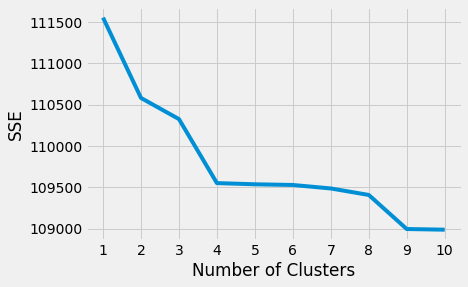

In [150]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [155]:
from kneed import KneeLocator
kl = KneeLocator(
     range(1, 11), sse, curve="convex", direction="decreasing"
)

kl.elbow

4

In [ ]:
kmeans = KMeans(
     init="random",
     n_clusters=4,
     n_init=10,
     max_iter=300,
     random_state=42
)

kmeans.fit(vector.toarray())


kmeans.inertia_

In [157]:
 # A list holds the silhouette coefficients for each k
silhouette_coefficients = []

for k in range(2, 11):
    
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(vector.toarray())
    score = silhouette_score(vector.toarray(), kmeans.labels_)
    silhouette_coefficients.append(score)
    
silhouette_coefficients

[0.3497439615207332,
 0.3497988030417661,
 0.30185897348961543,
 0.2720325003413489,
 0.2720161365036005,
 0.27205782323408007,
 -0.024120890526704086,
 -0.0214590460842581,
 -0.021409559562845577]

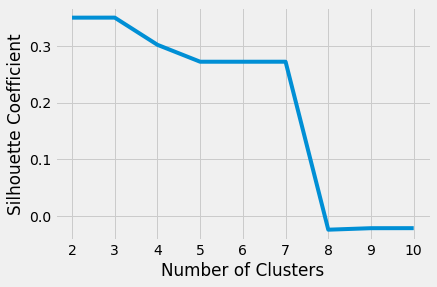

In [158]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [160]:
#The value of the silhouette coefﬁcient is between [-1, 1].
#A score of 1 denotes the best meaning that the data point i is very compact within the cluster to which it belongs and far away from the other clusters.
#The worst value is -1. Values near 0 denote overlapping clusters.

In [166]:
RANDOM_SEED = 42

no_comedy_df = df_red[df_red['category']!='Comedy']

train_df, dev_df, test_df = np.split(no_comedy_df.sample(frac=1, random_state=RANDOM_SEED),[int(.8*len(no_comedy_df)), int(.9*len(no_comedy_df))])



In [167]:
vectorizer_F = TfidfVectorizer(
            max_df=0.95,   # note: % of docs in collection
            max_features = 10000, # only top 10k by freq,
            lowercase = False, # keep capitalization
            min_df=10,  # note: absolute count of documents
            stop_words="english",
            ngram_range = (1,2), # include 2-word phrases
            use_idf=True,
            )



X_train = vectorizer_F.fit_transform(train_df.title)

# getting list of labels 
y_train = list(train_df.avg_views_since_pub)

reg = LinearRegression()
reg.fit(X_train,y_train)

rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf.fit(X_train,y_train)

X_dev = vectorizer_F.transform(dev_df.title)

y_dev = list(dev_df.avg_views_since_pub)

dummy_clf_mean = DummyRegressor(strategy="mean")
dummy_clf_mean.fit(X_train, y_train)
dummy_clf_median = DummyRegressor(strategy="median")
dummy_clf_median.fit(X_train, y_train)

lr_dev_preds = reg.predict(X_dev)
rf_dev_preds = rf.predict(X_dev)
mean_dev_preds = dummy_clf_mean.predict(X_dev)
median_dev_preds = dummy_clf_median.predict(X_dev)

rf_mse = mean_squared_error(y_dev, rf_dev_preds)
lr_mse = mean_squared_error(y_dev, lr_dev_preds)
mean_mse = mean_squared_error(y_dev, mean_dev_preds)
median_mse = mean_squared_error(y_dev, median_dev_preds)

print(rf_mse)
print(lr_mse)
print(mean_mse)
print(median_mse)

3301942.282271241
3390712.523464956
4002989.2471673223
4615912.678216722


In [195]:
import nltk 
nltk.download('stopwords')
import string
from nltk.corpus import stopwords
stopwords.words('english')

def title_cleaning(title):
    Test_punc_removed = [char for char in title if char not in string.punctuation]
    Test_punc_removed_join = ''.join(Test_punc_removed)
    Test_punc_removed_join_clean = [word for word in Test_punc_removed_join.split() if word.lower() not in stopwords.words('english')]
    return Test_punc_removed_join_clean

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [197]:
vectorizer = CountVectorizer(analyzer = title_cleaning)
title_countvectorizer = vectorizer.fit_transform(df['title'])

In [198]:
title_countvectorizer.shape

(55337, 51143)

In [199]:
X = pd.DataFrame(title_countvectorizer.toarray())

In [200]:
X

,0,1,2,3,4,5,6,7,8,9,...,51133,51134,51135,51136,51137,51138,51139,51140,51141,51142
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55332,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55333,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55334,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55335,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [236]:
test_df = pd.concat([X, df], axis=1)

test_df

,0,1,2,3,4,5,6,7,8,9,...,views,published,likes,comments,duration,tag,description,channel,category,length
0,0,0,0,0,0,0,0,0,0,0,...,463637,2021-11-05,18410,3552,PT1M38S,"[Cryptocurrency, Crypto, Bart Baker, Doge, Shi...","""POLYDOGE"" (OFFICIAL MUSIC VIDEO)\nJoin us on...",Bart Baker,Comedy,47
1,0,0,0,0,0,0,0,0,0,0,...,768016,2021-08-29,46351,11327,PT7M25S,"[BartBaker, China, Ping, SONAR, Crypto, Crypto...",I'm back. I'm sorry. Please forgive me. I love...,Bart Baker,Comedy,38
2,0,0,0,0,0,0,0,0,0,0,...,16015064,2018-08-24,262730,28384,PT4M21S,"[6ix9ine, 6ix9ine fefe, sixnine, sixnine fefe,...","6ix9ine, Nicki Minaj, Murda Beatz - ""FEFE"" PAR...",Bart Baker,Comedy,49
3,0,0,0,0,0,0,0,0,0,0,...,1650333,2018-06-14,28664,6593,PT11M5S,"[Gold Play Button, Destroying, smashing, play ...",▶ DOWNLOAD SQUAD RIVALS - https://qkq5h.app.go...,Bart Baker,Comedy,38
4,0,0,0,0,0,0,0,0,0,0,...,3808210,2018-06-09,83873,12373,PT1M18S,"[This is america, childish gambino, Childish G...","""This Is America""",Bart Baker,Comedy,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55332,0,0,0,0,0,0,0,0,0,0,...,1327691,2012-12-12,13997,565,PT7M58S,"[downward dog, down dog, downward facing dog, ...",Learn Downward Dog yoga pose with Adriene. If ...,Yoga With Adriene,Yoga,44
55333,0,0,0,0,0,0,0,0,0,0,...,162174,2012-11-14,2397,116,PT8M40S,"[yoga, adriene mishler, yoga with adriene, yog...",Learn the Reclined Twist Yoga Pose with Adrien...,Yoga With Adriene,Yoga,44
55334,0,0,0,0,0,0,0,0,0,0,...,336507,2012-10-31,4589,249,PT9M27S,"[yoga for beginners, yoga with adriene, founda...",Learn how to do the Corpse Pose with Adriene! ...,Yoga With Adriene,Yoga,31
55335,0,0,0,0,0,0,0,0,0,0,...,1451610,2012-10-24,11649,373,PT6M14S,"[extended child's pose, yoga for beginners, ch...",Learn Extended Child's Pose with Adriene! This...,Yoga With Adriene,Yoga,41


In [237]:
test_df['Today'] = datetime.today().strftime('%Y-%m-%d') 
test_df.Today = pd.to_datetime(test_df.Today, format='%Y-%m-%d')
test_df['days since'] = test_df['Today'] - test_df['published']
test_df['days since'] = test_df['days since'].apply(lambda x: x.days)
test_df['avg_views_since_pub'] = test_df['views'] / test_df['days since']

In [241]:
def remove_outliers(df,columns,n_std):
    for col in columns:
        print('Working on column: {}'.format(col))
        
        mean = df[col].mean()
        sd = df[col].std()
        
        df = df[(df[col] <= mean+(n_std*sd))]
        
    return df

columns = ['views','avg_views_since_pub']
n_std = 3


df_red = remove_outliers(test_df,columns,n_std)
len(df_red)

Working on column: views


MemoryError: Unable to allocate 21.1 GiB for an array with shape (51146, 55337) and data type int64

In [ ]:
# cluster data to find out if titles cluster by catgeory, which could mean that it is better to have a model per category 

In [ ]:
# change target to score from 1 - 10 in terms of quality 